# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
!mkdir checkpoints
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

mkdir: cannot create directory ‘checkpoints’: File exists
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

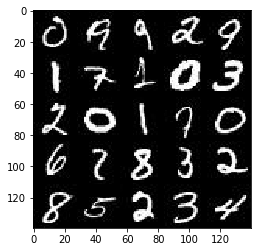

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

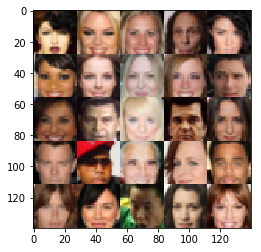

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [13]:
def discriminator(images, reuse=False, alpha=0.2, dropout=0.5, is_train=True):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d()
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=kernel_initializer)
        x1 = tf.maximum(alpha * x1, x1)
        # x1 = tf.layers.dropout(x1, rate=dropout, training=is_train)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', kernel_initializer=kernel_initializer)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # x2 = tf.layers.dropout(x2, rate=dropout, training=is_train)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', kernel_initializer=kernel_initializer)
        x3 = tf.layers.batch_normalization(x2, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # x3 = tf.layers.dropout(x3, rate=dropout, training=is_train)
        # 4x4x256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, dropout=0.5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d()
    with tf.variable_scope('generator', reuse= not is_train):
        # fully connected layer
        x1 = tf.layers.dense(z, 4*4*1024)
        x1 = tf.reshape(x1, (-1, 4, 4, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1, rate=dropout, training=is_train)
        # 4x4x1024
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='same', kernel_initializer=kernel_initializer)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2, rate=dropout, training=is_train)
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same', kernel_initializer=kernel_initializer)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, rate=dropout, training=is_train)
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=2, padding='same', kernel_initializer=kernel_initializer)
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.layers.dropout(x4, rate=dropout, training=is_train)
        
        x5 = tf.layers.conv2d_transpose(x4, 64, 5, strides=2, padding='same', kernel_initializer=kernel_initializer)
        x5 = tf.layers.batch_normalization(x5, training=is_train)
        x5 = tf.maximum(alpha * x5, x5)
        x5 = tf.layers.dropout(x5, rate=dropout, training=is_train)
        
        logits = tf.layers.conv2d_transpose(x5, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=kernel_initializer)
        logits = tf.image.resize_images(logits, (28,28))
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1, dropout=0.5):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, dropout=dropout)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha, dropout=dropout)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha, dropout=dropout)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        # Further improve by using SGD for discriminator
        # d_train_opt = tf.train.GradientDescentOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    return samples

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
          alpha=0.2, smooth=0.1, dropout=0.5):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tf.reset_default_graph()
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=alpha, smooth=smooth, dropout=dropout)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Normalize batch_images to the range of -1 to 1
                batch_images = batch_images * 2
                
                # Sample random noise for the generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run the optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                # Optimize generator twice, for every iteration, This will help the generative model to optimize better
                # _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    gen_samples = show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                    samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator_%s.ckpt' %data_image_mode)
        
    return samples, losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4665... Generator Loss: 0.7323
Epoch 1/2... Discriminator Loss: 1.4080... Generator Loss: 0.7762
Epoch 1/2... Discriminator Loss: 1.2881... Generator Loss: 0.8665
Epoch 1/2... Discriminator Loss: 1.2235... Generator Loss: 0.9159
Epoch 1/2... Discriminator Loss: 1.1856... Generator Loss: 0.9637
Epoch 1/2... Discriminator Loss: 1.1040... Generator Loss: 1.0291
Epoch 1/2... Discriminator Loss: 1.0467... Generator Loss: 1.1020
Epoch 1/2... Discriminator Loss: 1.0227... Generator Loss: 1.1472
Epoch 1/2... Discriminator Loss: 0.9348... Generator Loss: 1.1855
Epoch 1/2... Discriminator Loss: 0.8915... Generator Loss: 1.2070


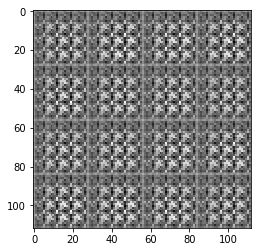

Epoch 1/2... Discriminator Loss: 0.9635... Generator Loss: 1.2454
Epoch 1/2... Discriminator Loss: 1.0170... Generator Loss: 1.1466
Epoch 1/2... Discriminator Loss: 1.1319... Generator Loss: 1.0373
Epoch 1/2... Discriminator Loss: 1.1451... Generator Loss: 1.0055
Epoch 1/2... Discriminator Loss: 1.1044... Generator Loss: 1.0150
Epoch 1/2... Discriminator Loss: 1.1273... Generator Loss: 1.0027
Epoch 1/2... Discriminator Loss: 1.1538... Generator Loss: 0.9583
Epoch 1/2... Discriminator Loss: 1.2431... Generator Loss: 0.9002
Epoch 1/2... Discriminator Loss: 1.2573... Generator Loss: 0.8845
Epoch 1/2... Discriminator Loss: 1.1918... Generator Loss: 0.9397


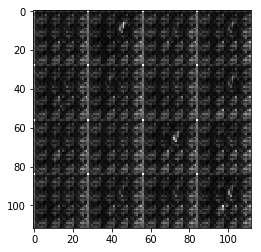

Epoch 1/2... Discriminator Loss: 1.2075... Generator Loss: 0.8819
Epoch 1/2... Discriminator Loss: 1.2320... Generator Loss: 0.8840
Epoch 1/2... Discriminator Loss: 1.2685... Generator Loss: 0.8766
Epoch 1/2... Discriminator Loss: 1.2312... Generator Loss: 0.8953
Epoch 1/2... Discriminator Loss: 1.2404... Generator Loss: 0.8798
Epoch 1/2... Discriminator Loss: 1.2105... Generator Loss: 0.9385
Epoch 1/2... Discriminator Loss: 1.2174... Generator Loss: 0.9070
Epoch 1/2... Discriminator Loss: 1.1442... Generator Loss: 0.9742
Epoch 1/2... Discriminator Loss: 1.1549... Generator Loss: 0.9609
Epoch 1/2... Discriminator Loss: 1.2133... Generator Loss: 0.8990


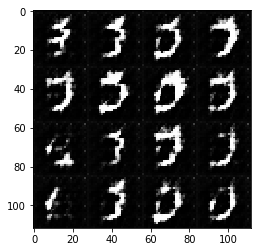

Epoch 1/2... Discriminator Loss: 1.2279... Generator Loss: 0.8924
Epoch 1/2... Discriminator Loss: 1.2025... Generator Loss: 0.8941
Epoch 1/2... Discriminator Loss: 1.2905... Generator Loss: 0.8659
Epoch 1/2... Discriminator Loss: 1.2603... Generator Loss: 0.8431
Epoch 1/2... Discriminator Loss: 1.2556... Generator Loss: 0.8696
Epoch 1/2... Discriminator Loss: 1.1584... Generator Loss: 0.9634
Epoch 1/2... Discriminator Loss: 1.1944... Generator Loss: 0.8872
Epoch 1/2... Discriminator Loss: 1.1864... Generator Loss: 0.9303
Epoch 1/2... Discriminator Loss: 1.1897... Generator Loss: 0.9279
Epoch 1/2... Discriminator Loss: 1.2067... Generator Loss: 0.9379


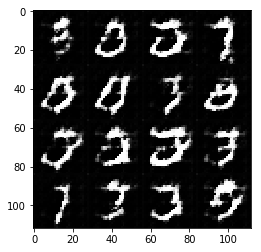

Epoch 1/2... Discriminator Loss: 1.2723... Generator Loss: 0.8661
Epoch 1/2... Discriminator Loss: 1.2501... Generator Loss: 0.8867
Epoch 1/2... Discriminator Loss: 1.3022... Generator Loss: 0.8663
Epoch 1/2... Discriminator Loss: 1.2317... Generator Loss: 0.9017
Epoch 1/2... Discriminator Loss: 1.2464... Generator Loss: 0.9420
Epoch 1/2... Discriminator Loss: 1.2714... Generator Loss: 0.9135
Epoch 1/2... Discriminator Loss: 1.3137... Generator Loss: 0.8358
Epoch 1/2... Discriminator Loss: 1.2925... Generator Loss: 0.8618
Epoch 1/2... Discriminator Loss: 1.3222... Generator Loss: 0.8287
Epoch 1/2... Discriminator Loss: 1.2966... Generator Loss: 0.8865


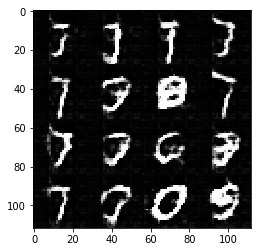

Epoch 1/2... Discriminator Loss: 1.3047... Generator Loss: 0.8558
Epoch 1/2... Discriminator Loss: 1.2220... Generator Loss: 0.8792
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 0.8905
Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 0.8431
Epoch 1/2... Discriminator Loss: 1.2517... Generator Loss: 0.9180
Epoch 1/2... Discriminator Loss: 1.3097... Generator Loss: 0.8287
Epoch 1/2... Discriminator Loss: 1.3049... Generator Loss: 0.8398
Epoch 1/2... Discriminator Loss: 1.2946... Generator Loss: 0.8564
Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 0.8403
Epoch 1/2... Discriminator Loss: 1.3812... Generator Loss: 0.8109


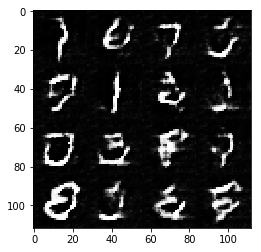

Epoch 1/2... Discriminator Loss: 1.3033... Generator Loss: 0.8566
Epoch 1/2... Discriminator Loss: 1.2743... Generator Loss: 0.8815
Epoch 1/2... Discriminator Loss: 1.2762... Generator Loss: 0.8579
Epoch 1/2... Discriminator Loss: 1.3414... Generator Loss: 0.8247
Epoch 1/2... Discriminator Loss: 1.3263... Generator Loss: 0.8366
Epoch 1/2... Discriminator Loss: 1.3135... Generator Loss: 0.8272
Epoch 1/2... Discriminator Loss: 1.3117... Generator Loss: 0.8626
Epoch 1/2... Discriminator Loss: 1.3559... Generator Loss: 0.8032
Epoch 1/2... Discriminator Loss: 1.2934... Generator Loss: 0.8701
Epoch 1/2... Discriminator Loss: 1.3442... Generator Loss: 0.8554


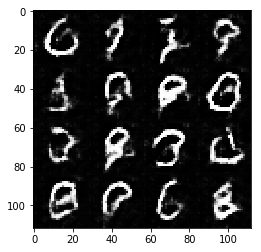

Epoch 1/2... Discriminator Loss: 1.3163... Generator Loss: 0.8569
Epoch 1/2... Discriminator Loss: 1.3378... Generator Loss: 0.8377
Epoch 1/2... Discriminator Loss: 1.3345... Generator Loss: 0.8219
Epoch 1/2... Discriminator Loss: 1.3324... Generator Loss: 0.8065
Epoch 1/2... Discriminator Loss: 1.2860... Generator Loss: 0.8615
Epoch 1/2... Discriminator Loss: 1.3256... Generator Loss: 0.8349
Epoch 1/2... Discriminator Loss: 1.3565... Generator Loss: 0.8130
Epoch 1/2... Discriminator Loss: 1.4245... Generator Loss: 0.7880
Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 0.7932
Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 0.8293


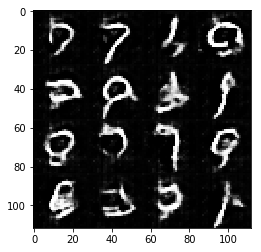

Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.8639
Epoch 1/2... Discriminator Loss: 1.3030... Generator Loss: 0.8506
Epoch 1/2... Discriminator Loss: 1.3001... Generator Loss: 0.8286
Epoch 1/2... Discriminator Loss: 1.3610... Generator Loss: 0.8094
Epoch 1/2... Discriminator Loss: 1.3493... Generator Loss: 0.8184
Epoch 1/2... Discriminator Loss: 1.3273... Generator Loss: 0.8314
Epoch 1/2... Discriminator Loss: 1.3361... Generator Loss: 0.8223
Epoch 1/2... Discriminator Loss: 1.3313... Generator Loss: 0.8572
Epoch 1/2... Discriminator Loss: 1.3553... Generator Loss: 0.8067
Epoch 1/2... Discriminator Loss: 1.3362... Generator Loss: 0.8235


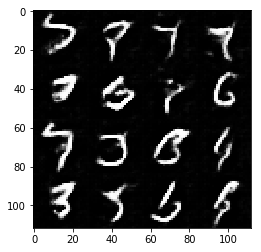

Epoch 1/2... Discriminator Loss: 1.3495... Generator Loss: 0.8210
Epoch 1/2... Discriminator Loss: 1.3223... Generator Loss: 0.8311
Epoch 1/2... Discriminator Loss: 1.3448... Generator Loss: 0.8140
Epoch 2/2... Discriminator Loss: 1.3272... Generator Loss: 0.8585
Epoch 2/2... Discriminator Loss: 1.3424... Generator Loss: 0.7954
Epoch 2/2... Discriminator Loss: 1.3292... Generator Loss: 0.8100
Epoch 2/2... Discriminator Loss: 1.2927... Generator Loss: 0.8590
Epoch 2/2... Discriminator Loss: 1.3525... Generator Loss: 0.8264
Epoch 2/2... Discriminator Loss: 1.3260... Generator Loss: 0.8472
Epoch 2/2... Discriminator Loss: 1.3220... Generator Loss: 0.8306


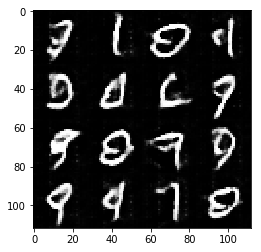

Epoch 2/2... Discriminator Loss: 1.3465... Generator Loss: 0.8393
Epoch 2/2... Discriminator Loss: 1.2645... Generator Loss: 0.8773
Epoch 2/2... Discriminator Loss: 1.3151... Generator Loss: 0.8540
Epoch 2/2... Discriminator Loss: 1.3055... Generator Loss: 0.8424
Epoch 2/2... Discriminator Loss: 1.2838... Generator Loss: 0.8495
Epoch 2/2... Discriminator Loss: 1.3041... Generator Loss: 0.8756
Epoch 2/2... Discriminator Loss: 1.2692... Generator Loss: 0.8672
Epoch 2/2... Discriminator Loss: 1.3188... Generator Loss: 0.8567
Epoch 2/2... Discriminator Loss: 1.3374... Generator Loss: 0.8432
Epoch 2/2... Discriminator Loss: 1.3081... Generator Loss: 0.8503


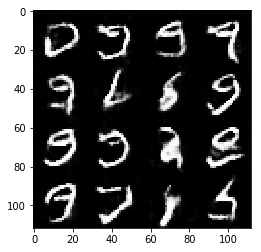

Epoch 2/2... Discriminator Loss: 1.3517... Generator Loss: 0.8274
Epoch 2/2... Discriminator Loss: 1.3405... Generator Loss: 0.8143
Epoch 2/2... Discriminator Loss: 1.2845... Generator Loss: 0.8486
Epoch 2/2... Discriminator Loss: 1.2901... Generator Loss: 0.8501
Epoch 2/2... Discriminator Loss: 1.3498... Generator Loss: 0.8072
Epoch 2/2... Discriminator Loss: 1.3323... Generator Loss: 0.8316
Epoch 2/2... Discriminator Loss: 1.3326... Generator Loss: 0.8332
Epoch 2/2... Discriminator Loss: 1.3228... Generator Loss: 0.8388
Epoch 2/2... Discriminator Loss: 1.3350... Generator Loss: 0.8544
Epoch 2/2... Discriminator Loss: 1.3168... Generator Loss: 0.8595


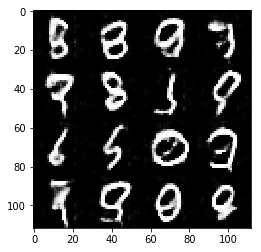

Epoch 2/2... Discriminator Loss: 1.3401... Generator Loss: 0.8047
Epoch 2/2... Discriminator Loss: 1.3139... Generator Loss: 0.8613
Epoch 2/2... Discriminator Loss: 1.3406... Generator Loss: 0.7966
Epoch 2/2... Discriminator Loss: 1.3076... Generator Loss: 0.8471
Epoch 2/2... Discriminator Loss: 1.3865... Generator Loss: 0.7993
Epoch 2/2... Discriminator Loss: 1.2977... Generator Loss: 0.8508
Epoch 2/2... Discriminator Loss: 1.3817... Generator Loss: 0.7803
Epoch 2/2... Discriminator Loss: 1.3090... Generator Loss: 0.8841
Epoch 2/2... Discriminator Loss: 1.2931... Generator Loss: 0.8598
Epoch 2/2... Discriminator Loss: 1.3524... Generator Loss: 0.8149


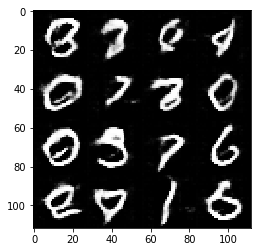

Epoch 2/2... Discriminator Loss: 1.3612... Generator Loss: 0.8173
Epoch 2/2... Discriminator Loss: 1.3331... Generator Loss: 0.8421
Epoch 2/2... Discriminator Loss: 1.3663... Generator Loss: 0.8310
Epoch 2/2... Discriminator Loss: 1.3229... Generator Loss: 0.8728
Epoch 2/2... Discriminator Loss: 1.3382... Generator Loss: 0.8151
Epoch 2/2... Discriminator Loss: 1.3687... Generator Loss: 0.7942
Epoch 2/2... Discriminator Loss: 1.3546... Generator Loss: 0.8154
Epoch 2/2... Discriminator Loss: 1.3048... Generator Loss: 0.8342
Epoch 2/2... Discriminator Loss: 1.3408... Generator Loss: 0.8191
Epoch 2/2... Discriminator Loss: 1.3229... Generator Loss: 0.8357


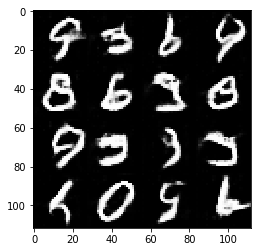

Epoch 2/2... Discriminator Loss: 1.3251... Generator Loss: 0.8556
Epoch 2/2... Discriminator Loss: 1.2820... Generator Loss: 0.8357
Epoch 2/2... Discriminator Loss: 1.3884... Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 1.3439... Generator Loss: 0.8124
Epoch 2/2... Discriminator Loss: 1.3307... Generator Loss: 0.8704
Epoch 2/2... Discriminator Loss: 1.3631... Generator Loss: 0.8355
Epoch 2/2... Discriminator Loss: 1.3862... Generator Loss: 0.8169
Epoch 2/2... Discriminator Loss: 1.3458... Generator Loss: 0.8178
Epoch 2/2... Discriminator Loss: 1.3229... Generator Loss: 0.8343
Epoch 2/2... Discriminator Loss: 1.3706... Generator Loss: 0.8117


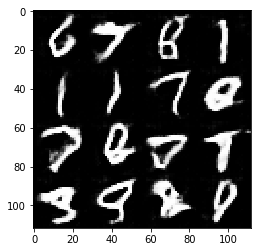

Epoch 2/2... Discriminator Loss: 1.3340... Generator Loss: 0.8529
Epoch 2/2... Discriminator Loss: 1.3498... Generator Loss: 0.8342
Epoch 2/2... Discriminator Loss: 1.3344... Generator Loss: 0.8059
Epoch 2/2... Discriminator Loss: 1.3223... Generator Loss: 0.8402
Epoch 2/2... Discriminator Loss: 1.3491... Generator Loss: 0.8500
Epoch 2/2... Discriminator Loss: 1.3212... Generator Loss: 0.8240
Epoch 2/2... Discriminator Loss: 1.3212... Generator Loss: 0.8298
Epoch 2/2... Discriminator Loss: 1.3474... Generator Loss: 0.8060
Epoch 2/2... Discriminator Loss: 1.3427... Generator Loss: 0.8078
Epoch 2/2... Discriminator Loss: 1.3476... Generator Loss: 0.8153


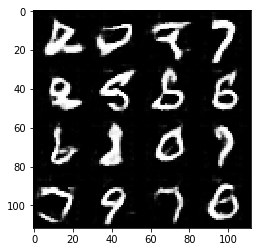

Epoch 2/2... Discriminator Loss: 1.3319... Generator Loss: 0.8346
Epoch 2/2... Discriminator Loss: 1.3383... Generator Loss: 0.8284
Epoch 2/2... Discriminator Loss: 1.3261... Generator Loss: 0.8135
Epoch 2/2... Discriminator Loss: 1.3269... Generator Loss: 0.8243
Epoch 2/2... Discriminator Loss: 1.3233... Generator Loss: 0.8369
Epoch 2/2... Discriminator Loss: 1.3358... Generator Loss: 0.7949
Epoch 2/2... Discriminator Loss: 1.2848... Generator Loss: 0.8371
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 0.8233
Epoch 2/2... Discriminator Loss: 1.3067... Generator Loss: 0.8422
Epoch 2/2... Discriminator Loss: 1.2944... Generator Loss: 0.8630


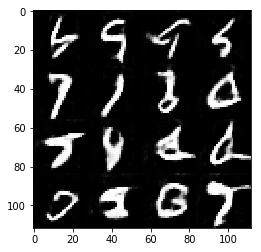

Epoch 2/2... Discriminator Loss: 1.3273... Generator Loss: 0.8442
Epoch 2/2... Discriminator Loss: 1.3308... Generator Loss: 0.8403
Epoch 2/2... Discriminator Loss: 1.3335... Generator Loss: 0.8317
Epoch 2/2... Discriminator Loss: 1.2995... Generator Loss: 0.8506
Epoch 2/2... Discriminator Loss: 1.3404... Generator Loss: 0.7932
Epoch 2/2... Discriminator Loss: 1.3600... Generator Loss: 0.8058
Epoch 2/2... Discriminator Loss: 1.3687... Generator Loss: 0.8141
Epoch 2/2... Discriminator Loss: 1.3334... Generator Loss: 0.8301
Epoch 2/2... Discriminator Loss: 1.2926... Generator Loss: 0.8501
Epoch 2/2... Discriminator Loss: 1.3345... Generator Loss: 0.8051


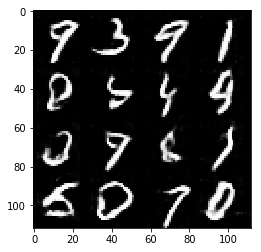

Epoch 2/2... Discriminator Loss: 1.3251... Generator Loss: 0.8380
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.7994
Epoch 2/2... Discriminator Loss: 1.2893... Generator Loss: 0.8315
Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 0.8239
Epoch 2/2... Discriminator Loss: 1.3459... Generator Loss: 0.7980
Epoch 2/2... Discriminator Loss: 1.3565... Generator Loss: 0.8085
Epoch 2/2... Discriminator Loss: 1.3330... Generator Loss: 0.8211


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
# Added parameters
alpha = 0.2
smooth = 0.1
dropout = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

_, _ = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha, smooth, dropout)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.6186... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.9448


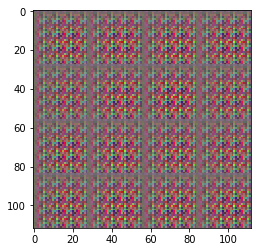

Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.9316
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 1.0113
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 1.0999
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 1.1677
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 1.1073
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 1.1214
Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 1.1180
Epoch 1/1... Discriminator Loss: 0.9092... Generator Loss: 1.2366
Epoch 1/1... Discriminator Loss: 0.9251... Generator Loss: 1.2753
Epoch 1/1... Discriminator Loss: 0.8692... Generator Loss: 1.3338


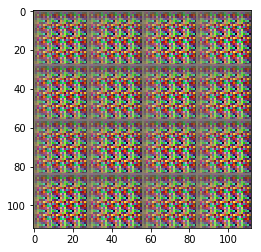

Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.3017
Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 1.1882
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 1.0301
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 1.0687
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 0.9373
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 0.9187


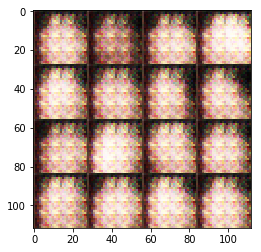

Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 1.0291
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.8957
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.8542


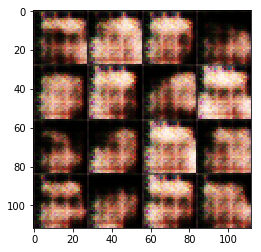

Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.7966


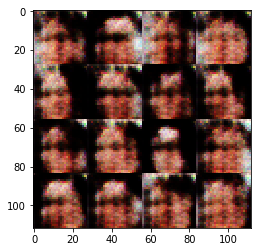

Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.8957
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.8793


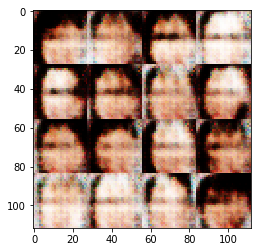

Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.9001


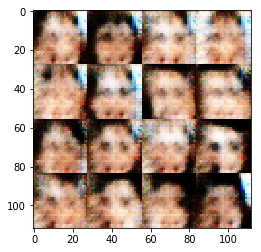

Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.8958
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 0.9372


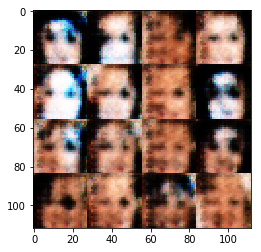

Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.9100


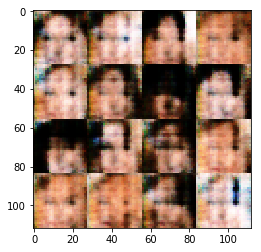

Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.8762
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.8486


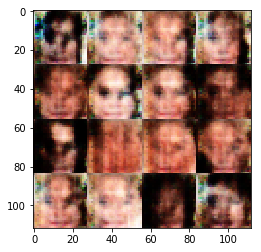

Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.9048


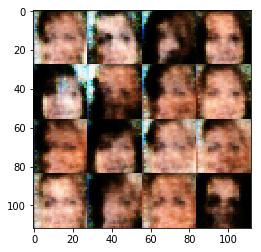

Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.8761


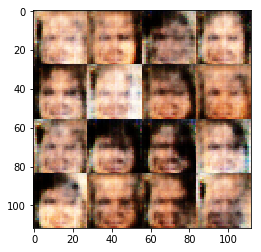

Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.9483
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.8139


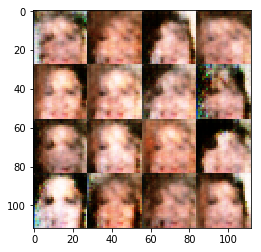

Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.8446


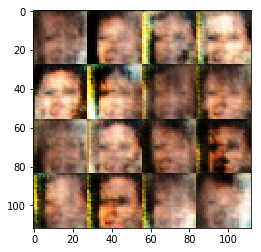

Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.9802
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.8943


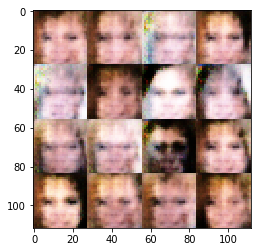

Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.9026


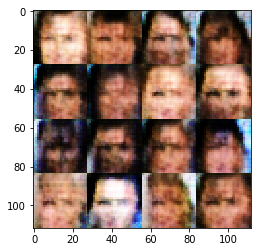

Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 0.9797
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.9835
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.8669


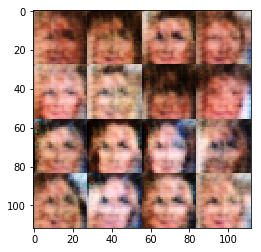

Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.8535
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.8372


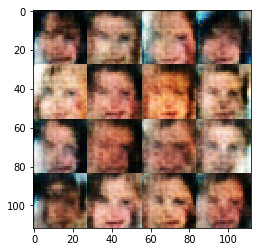

Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 0.8992


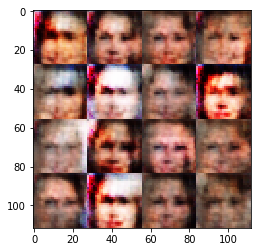

Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.8138


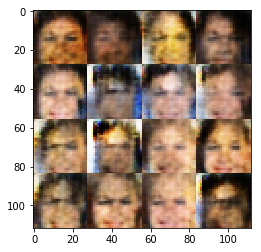

Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.8618


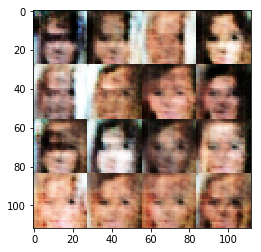

Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.8196


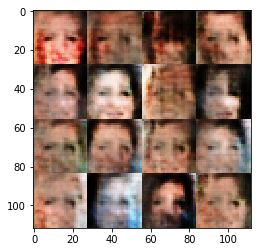

Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.8232


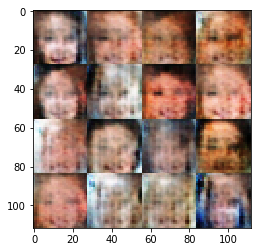

Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7547


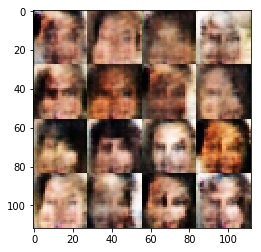

Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.8027


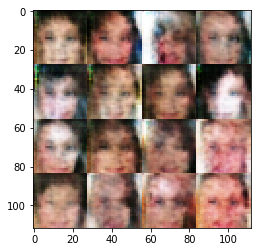

Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.8397


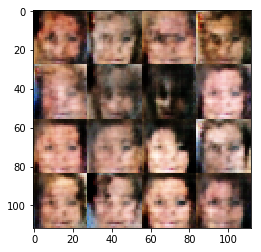

Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.8654


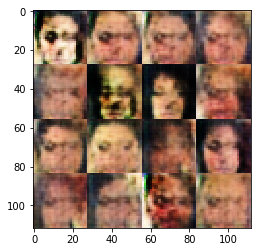

Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.8590


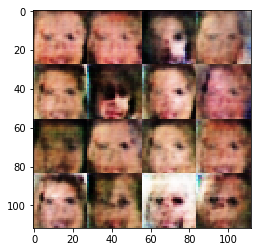

Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.8366


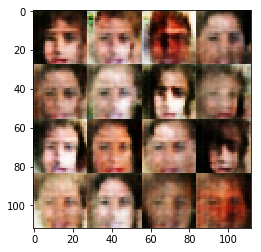

Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.8321


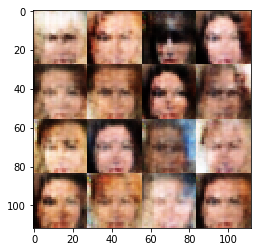

Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.7865


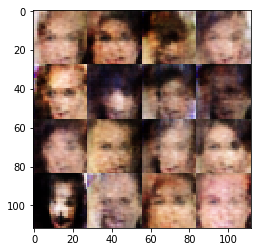

Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.8284


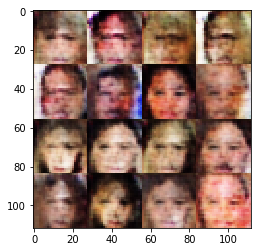

Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.8336


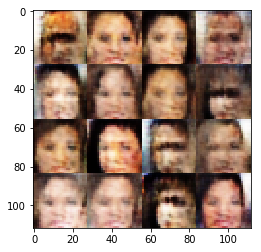

Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.8076


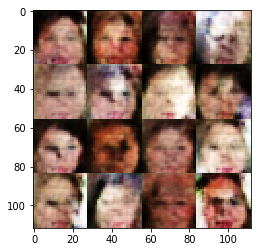

Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7684


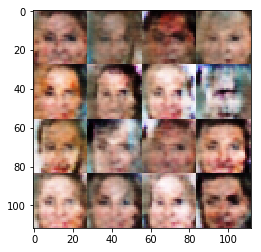

Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7960


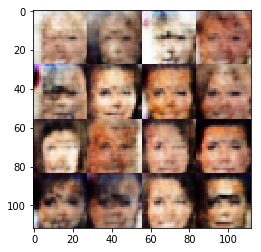

Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.8259


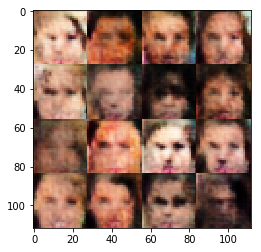

Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7924


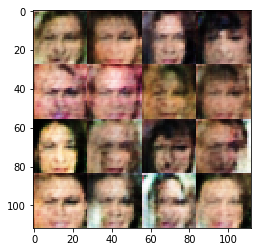

Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.8108


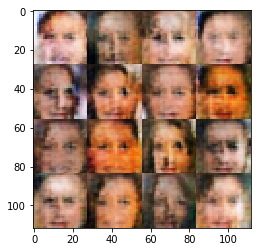

Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7688


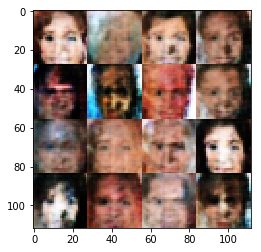

Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.8087


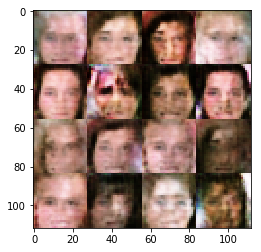

Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.8049


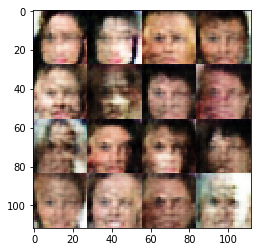

Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.7758


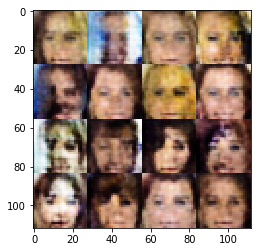

Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7635


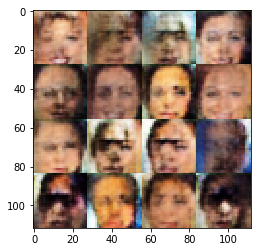

Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.8015


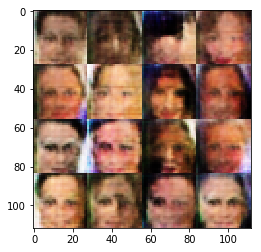

Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7561


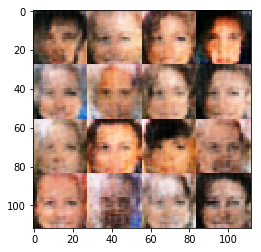

Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.7865


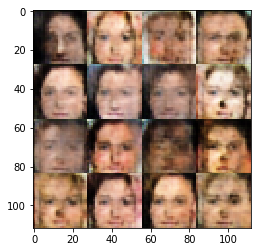

Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7549


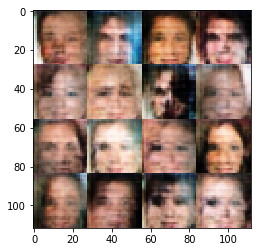

Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.7922


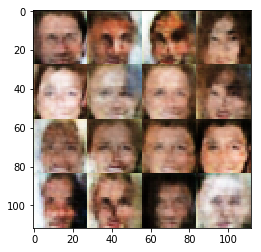

Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.8337


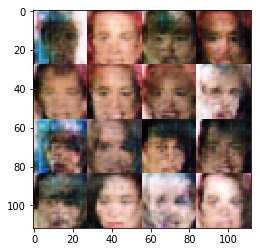

Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7911


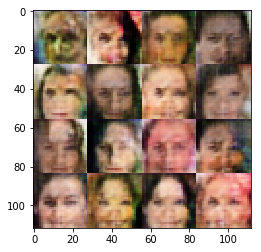

Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7811


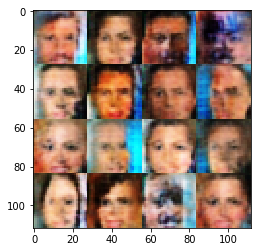

Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.8528


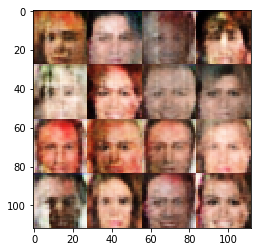

Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.7669


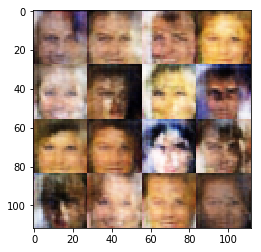

Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.8355


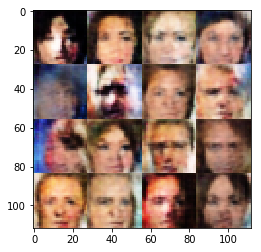

Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.8260


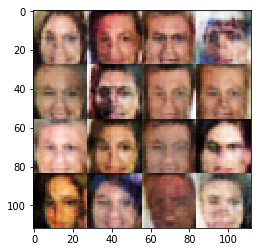

Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.8050


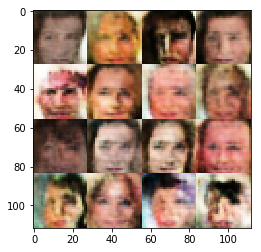

Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.8492


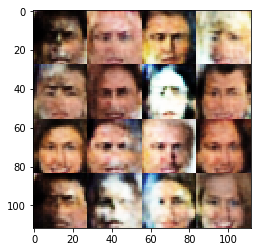

Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7755


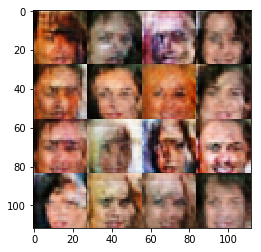

Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.7578


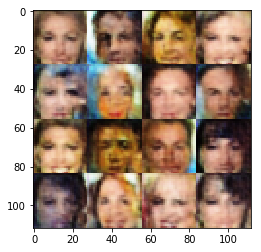

Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.7889


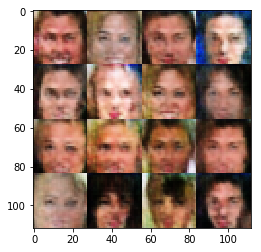

Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.8236


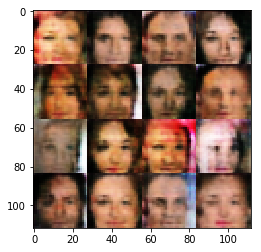

Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.8246


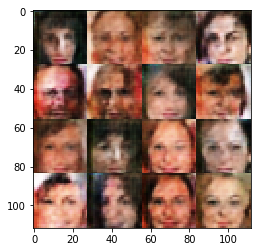

Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.8317


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
# Added parameters
alpha = 0.2
smooth = 0.1
dropout = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))

_, _ = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha, smooth, dropout)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.